# Lab 6 – Bayesian Classifiers and Gaussian Mixture Models

In this lab, we will study **Bayesian Classifiers**.  
A Bayes classifier applies **Bayes’ theorem** to compute the posterior probability of each class given an observation:

$$
P(y \mid x) = \frac{P(x \mid y) \, P(y)}{P(x)}
$$


You will implement two variants of the Bayes classifier, under different assumptions for the conditional probability $P(x \mid y)$:

1. **Gaussian Bayes Classifier**: $P(x \mid y) \sim \text{Gaussian Distribution (Normal)}$
2. **Gaussian Mixture Bayes Classifier**: $P(x \mid y) \sim \text{Gaussian Mixture Model (GMM)}$

We will start with a quick demonstration of **Gaussian Mixture Models** using `scikit-learn`.


# A. Gaussian Distribution

#### A1. One-dimensional Gaussian Distribution

The univariate (one-dimensional) Gaussian distribution with mean $\mu$ and variance $\sigma^2$ is defined as:

$$
p(x; \mu, \sigma^2) =
\mathcal{N}(x \mid \mu, \sigma^2) =
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\!\left(
    -\frac{(x - \mu)^2}{2\sigma^2}
\right)
$$

where:

- $x \in \mathbb{R}$: observed value (feature)  
- $\mu \in \mathbb{R}$: mean of the distribution  
- $\sigma^2 \in \mathbb{R}^+$: variance of the distribution  

The value of the density at a particular point $x$ represents the **relative likelihood** of observing that value under the given Gaussian distribution.


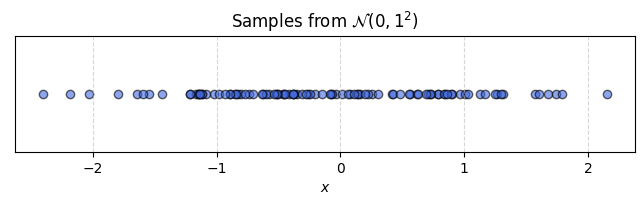

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Parameters
mu = 0       # mean
sigma = 1    # standard deviation

# Sample random points
X = np.random.normal(mu, sigma, size=100)

# Plot sampled points on a line
plt.figure(figsize=(8, 1.5))
plt.scatter(X, np.zeros_like(X), color='royalblue', alpha=0.6, edgecolor='k')
plt.title(fr'Samples from $\mathcal{{N}}({mu}, {sigma}^2)$')
plt.xlabel("$x$")
plt.yticks([])
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

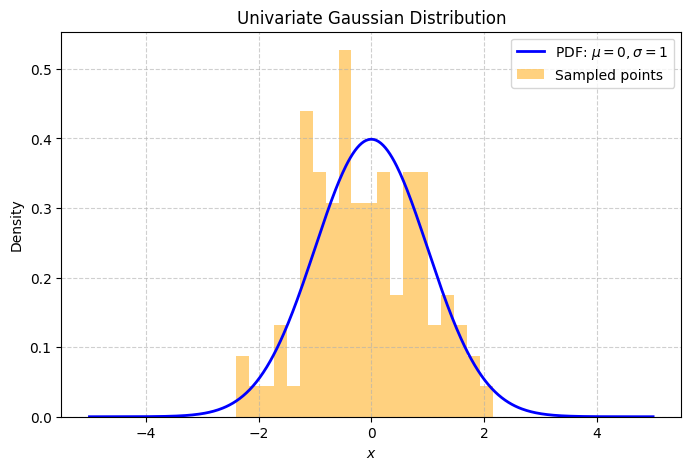

In [3]:
# Create x-axis for pdf
x = np.linspace(-5, 5, 500) # this is to plot the density function from [-5,5]
pdf = norm.pdf(x, mu, sigma)

# Plot the pdf and the sampled points
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, 'b-', label=fr'PDF: $\mu={mu}, \sigma={sigma}$', linewidth=2)
plt.hist(X, bins=20, density=True, alpha=0.5, color='orange', label='Sampled points')

plt.title("Univariate Gaussian Distribution")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

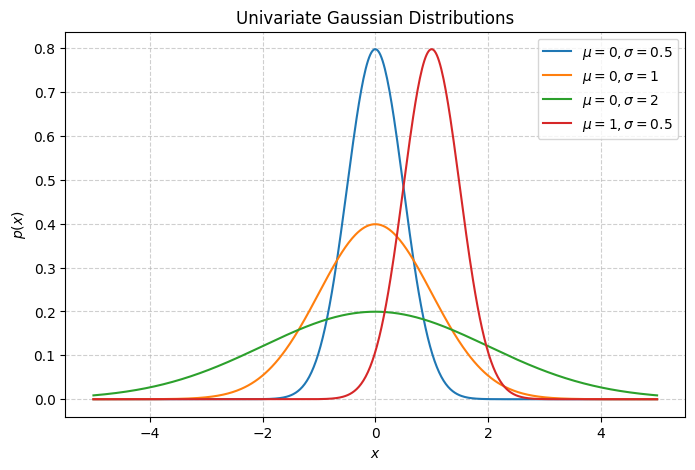

In [4]:
# Define parameters
mu_values = [0, 0, 0, 1]
sigma_values = [0.5, 1, 2, 0.5]
x = np.linspace(-5, 5, 500)

# Plot Gaussian pdfs for different standard deviations
plt.figure(figsize=(8, 5))
for mu, sigma in zip(mu_values, sigma_values):
    plt.plot(x, norm.pdf(x, mu, sigma), label=fr'$\mu={mu}, \sigma={sigma}$')

plt.title("Univariate Gaussian Distributions")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### A2. Multivariate Gaussian Distribution

The multivariate Gaussian (Normal) distribution with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$ is defined as:

$$
p(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = 
\mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma}) =
\frac{
    \exp\!\left(
        -\tfrac{1}{2}
        (\mathbf{x} - \boldsymbol{\mu})^{\mathrm{T}}
        \boldsymbol{\Sigma}^{-1}
        (\mathbf{x} - \boldsymbol{\mu})
    \right)
}{
    \sqrt{(2\pi)^d \, |\boldsymbol{\Sigma}|}
}
$$

where:

- $\mathbf{x} \in \mathbb{R}^d$: feature vector  
- $\boldsymbol{\mu} \in \mathbb{R}^d$: mean vector  
- $\boldsymbol{\Sigma} \in \mathbb{R}^{d \times d}$: covariance matrix  

The value of the density at a particular point $\mathbf{x}$ represents the **relative likelihood** of observing that value under the given Gaussian distribution.

Covariance measures how two random variables change together.  
Specifically, it quantifies whether increases in one variable tend to be associated with increases or decreases in another.

- If the covariance is **positive**, when one variable increases, the other tends to increase as well.  
- If the covariance is **negative**, when one variable increases, the other tends to decrease.  
- If the covariance is **zero** (or close to zero), the variables are uncorrelated, meaning there is no linear relationship between them.

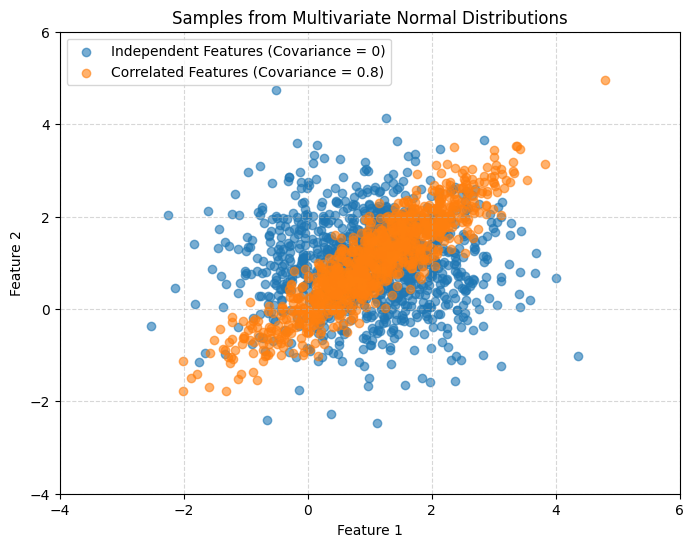

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data with independent features (zero covariance)
X = np.random.multivariate_normal(
    mean=[1, 1], 
    cov=[[1, 0.0],
         [0.0, 1]],
    size=1000
)

# Generate data with correlated features (non-zero covariance)
X2 = np.random.multivariate_normal(
    mean=[1, 1], 
    cov=[[1, 0.9],
         [0.9, 1]],
    size=1000
)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], label="Independent Features (Covariance = 0)", alpha=0.6)
plt.scatter(X2[:, 0], X2[:, 1], label="Correlated Features (Covariance = 0.8)", alpha=0.6)
plt.xlim(-4, 6)
plt.ylim(-4, 6)
plt.title("Samples from Multivariate Normal Distributions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
plt.close()


### Parameter Inference for a Multivariate Gaussian

Given a dataset of samples $X = \{ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n \}$, where each sample $\mathbf{x}_i \in \mathbb{R}^d$, we estimate the parameters of the Gaussian distribution — the mean vector and covariance matrix — using **Maximum Likelihood Estimation (MLE)**.

1. **Mean vector** $\hat{\boldsymbol{\mu}}$:

$$
\hat{\boldsymbol{\mu}} = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i
$$

2. **Covariance matrix** $\hat{\boldsymbol{\Sigma}}$:

$$
\hat{\boldsymbol{\Sigma}} = \frac{1}{n} \sum_{i=1}^n (\mathbf{x}_i - \hat{\boldsymbol{\mu}})(\mathbf{x}_i - \hat{\boldsymbol{\mu}})^\top
$$

In [6]:
# example of the multi variate normal distribution with scipy
mean_est = np.mean(X,axis=0)
cov_est = np.cov(X, rowvar=False)

In [7]:
mean_est

array([0.97665066, 0.9667694 ])

In [8]:
cov_est

array([[1.06431316, 0.00261345],
       [0.00261345, 0.95215211]])

In [9]:
from scipy.stats import multivariate_normal as mvn
dist = mvn(mean=mean_est, cov=cov_est)
x = [0, 0]
print("PDF:", dist.pdf(x))

PDF: 0.06197622767227749


### A3. Gaussian Mixture of  model:

$$p_{GMM}(x_{1},\ldots ,x_{d})= \sum_{i=1}^{k} w_k p(x_{1},\ldots ,x_{k};  \mu_i,\Sigma_i),s.t  \sum_{i=1}^{k} w_k  = 1$$


The model can be fit using the EM algorithm to find our parameters :
 1. $ w_k $ : weight of each gaussian, or the prior probability of the gaussian k, p(k)
 1. $ \mu_k $ : the mean of each the gaussian 
 1. $ \Sigma_k $: the covariance of each gaussian

![Sample Plot](./figures_set2/multimodal.jpg)

lets generate some data

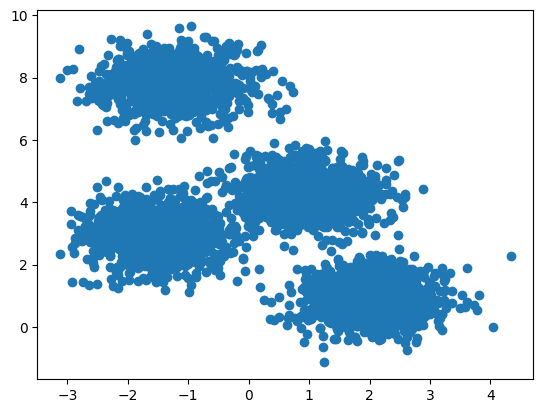

In [10]:
from sklearn.datasets._samples_generator import make_blobs
import matplotlib.pyplot as plt

# generate some data
X, y_true = make_blobs(n_samples=4000, centers=4, cluster_std=0.60, random_state=0)

plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()
plt.close()

### Parameter inference

To estimate the parameters of the distribution, scikit-learn uses the Expectation–Maximization algorithm.

In [11]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
gmm.fit(X) # find the parameters of each gaussian

GaussianMixture(n_components=4)

In [12]:
# weights of each Gaussian i.e p(k)
w_k = gmm.weights_
w_k

array([0.25010392, 0.24995563, 0.25065202, 0.24928842])

In [13]:
# mean of each gaussian
means = gmm.means_
means

array([[ 2.01630043,  0.90234062],
       [-1.23824476,  7.81555656],
       [-1.5205758 ,  2.92071074],
       [ 0.95919476,  4.29696274]])

In [14]:
# mean of each gaussian
cov = gmm.covariances_
cov

array([[[ 0.3521316 , -0.00251558],
        [-0.00251558,  0.34816653]],

       [[ 0.37956024, -0.00096594],
        [-0.00096594,  0.33053861]],

       [[ 0.35307953, -0.00442887],
        [-0.00442887,  0.36458914]],

       [[ 0.34150938, -0.00421972],
        [-0.00421972,  0.34663498]]])

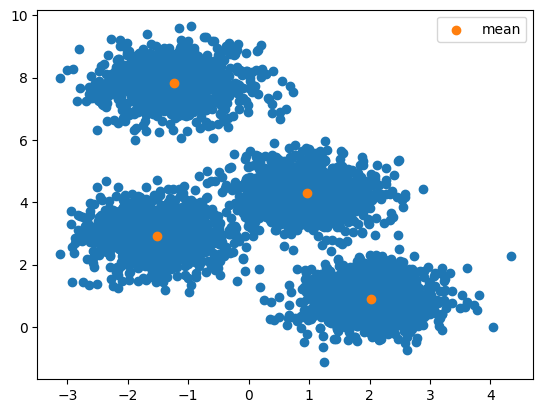

In [15]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], label="mean")
plt.legend()
plt.show()
plt.close()

# Probability Density Function of Gaussian Mixture Model

$$p_{GMM}(x_{1},\ldots ,x_{k})= \sum_{i=1}^{k} w_k p(x_{1},\ldots ,x_{k};  \mu_i,\Sigma_i),s.t  \sum_{i=1}^{k} w_k  = 1$$

In [16]:
# pdf of gmm
x = (0, 0)


def pdf_mixture(x, w, means, cov):
    n_componets = len(means)
    p_x = 0
    for k in range(n_componets):
        p_x += w[k] * mvn(mean=means[k], cov=cov[k]).pdf(x)
    return p_x

In [17]:
pdf_mixture(x, w_k, means, cov)

0.00010584089218250922

### notes 1.  if we use covariance_type="diag" the covariance metrix is diagonal

In [18]:
gmm = GaussianMixture(n_components=4, covariance_type="diag")
gmm.fit(X)

GaussianMixture(covariance_type='diag', n_components=4)

In [19]:
# so the cov in a list with the components of the diagonal
gmm.covariances_

array([[0.34120551, 0.34680435],
       [0.37956783, 0.33056489],
       [0.35218237, 0.34835942],
       [0.35306517, 0.36506761]])

# Assignment
## Bayesian Classifier with Gaussian Model

We begin with the implementation of the Gaussian Naive Bayes Classifier.

In the Bayesian Classifier, we use Bayes' theorem to calculate $ p(y|x) $:

$$ 
p(y|x) = \frac{p(x|y) \cdot p(y)}{p(x)} 
$$

This can be rewritten as:

$$ 
p(y|x) = \frac{p(x|y) \cdot p(y)}{\sum_{y'} p(x|y') p(y')} 
$$ 

In the Gaussian Naive Bayes Classifier, we assume that $ p(x|y) $ follows a Gaussian distribution: 

$$p(x|y) \sim \mathcal{N}(\mathbf {x} | \mu, \Sigma) $$

with the parameters $\mu$ and $\Sigma$ depending on the class $y$. 

In addition, the Naive Bayes classifier assumes **independence** of the features conditioned on the label, i.e., a **diagonal covariance matrix** for the Gaussian $ p(x|y) $.

So the Naive Bayes Classifier, you need to calculate:

1. The prior for each class $p(y)$ according to their empirical values.
2. The parameters of the Gaussian distribution for each class $y$ to model $ p(x|y) $ according to their empirical values.
3. Use Bayes' theorem to predict $ p(y|x) $.

The final prediction of our model can be the class with the maximum probability $p(y|x)$.

# Step 1.

Fill the class below and use it to:   
A. Fit your model using .fit() method  
B. Get the propabilities of each class for the different X using .predict_proba() method  
C. Make the final predictions using the .predict() method and calculate the accuracy of your model  

Hints:
So to fit the model want:
1. Calculate the prior p(y) by calculating the percentage of samples in each class y.
2. Find the parameters (mean and covariance matrix) of the gaussian p(x|y) for **each class y**.   
We can do this by calculating the empirical mean and covariance matrix of Data X for each class y.
3. then use the bayes theorem to calculate p(y|x)

In [20]:
class GaussianNaiveBayesClassifier:
    """
    Implementation of Naive Bayes Classifier
    """

    def __init__(self):
        # initialization of required variables.
        self.models = None  # p(x|y)
        self.prior = None  # p(y)
        self.classes = None # the classes
        self.n_classes = None # number of classes
        self.n_features = None # dimension of the features

    def fit(self, X, y):
        """
        Calculate the parameters of the gaussian models for each class y i.e P(x|y),
        as well as the prior class probabilities P(y).
        :param X: The input features
        :param y: The labels
        :return: nothing
        """
        self.n_features = X.shape[1]
        num_of_points= X.shape[0]
        
        self.classes = list(set(y))
        self.n_classes = len(set(y))
        
        #
        self.prior = np.zeros(self.n_classes)
        self.models = []
        for y_index in range(self.n_classes):
            class_y = # fill your code # set the value for y
            
            # 1. Calculate the prior P(y) for each class
            p_y = #fill your code  
            self.prior[y_index] =  p_y
            
            # 2. Estimate the parameters of the gaussian model P(x|y)
            # we will find the parameters of the gaussian for each class
            data_x_y = #fill your code        # get the data that only in class y
            
            mean_x_y = #fill your code        # calculate the mean
            cov_x_y = #fill your code         # calculate the covariance matrix, Note that you have to set rowvar=False
            diag_cov_x_y = #fill your code    # get the diagonal as the naive bayes implies
            
            gaussian = mvn(mean=mean_x_y, cov=diag_cov_x_y) #fill your code
            self.models += [gaussian] # add the model p(x|y) in your model list
        
    def predict_proba(self, X):
        """
        Calculate the posterior probability of each class given the features, i.e. P(y|x).
        You can calculate this with Bayes's theorem:
                    P(y|x) = P(x|y) P(y) / P(x).
                    P(y|x): The Posterior probability
                    P(x|y): The Likelihood probability -  the model in self.models[y].pdf(x)
                    P(y): Prior probability
                    P(x): The evidence \sum_{y'} P(x|y') P(y')
        :param X:
        :return:
        """
        # get general information
        n_examples = X.shape[0]

        # fill your code to calculate P(y|x)
        posterior = 
        return posterior
    

    def predict(self, X):
        """
        Make predicted class with the maximum posterior P(y|x)
        :param X:
        :return: the predicted class
        hint: use the predict_proba class
        """
        posterior = 
        prediction = 
        return prediction

SyntaxError: invalid syntax (4289796219.py, line 32)

In [21]:
# let's generate some data to use to train our models
centers = [(-10, 5), (0, 0), (0, 10), (-7, 10)]
X_y_0, _ = make_blobs(n_samples=4000, centers=centers, cluster_std=1.00, random_state=0)
centers = [(-5, 5), (-5, -2)]
X_y_1, _ = make_blobs(n_samples=2000, centers=centers, cluster_std=1.00, random_state=0)
X = np.concatenate([X_y_0, X_y_1], axis=0)
Y = np.concatenate([[0] * 4000, [1] * 2000], axis=0)

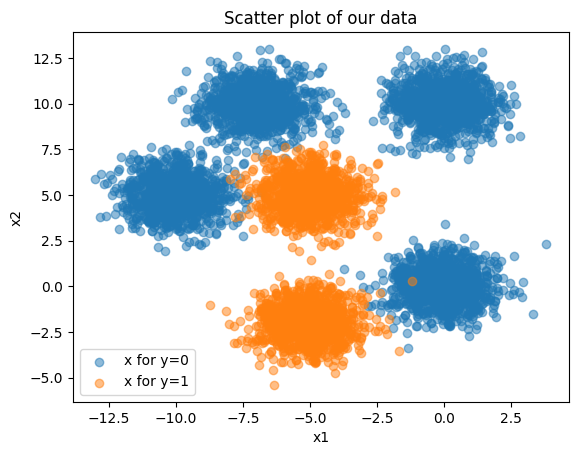

In [22]:
# plt.scatter(X[:,0], X[:,1], color =["r" if y == 1 else "g" for y in Y], alpha = 0.5)
plt.figure()
plt.title("Scatter plot of our data")
plt.scatter(X_y_0[:, 0], X_y_0[:, 1], alpha=0.5, label="x for y=0")
plt.scatter(X_y_1[:, 0], X_y_1[:, 1], alpha=0.5, label="x for y=1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [ ]:
# initial the classifier object
gaussian_naive_bayes = GaussianNaiveBayesClassifier()

# fit the model
gaussian_naive_bayes.fit(X=X,y=Y)

In [ ]:
# get predict propabilities for each class
posterior = 
posterior

In [ ]:
# get predict propabilities for each class
y_pred = 
y_pred

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true = Y, y_pred=y_pred)

In [ ]:
mean_0 = gaussian_naive_bayes.models[0].mean
X_y_pred_0 = X[y_pred==0]

mean_1 = gaussian_naive_bayes.models[1].mean
X_y_pred_1 = X[y_pred==1]

plt.figure()
plt.title("Scatter plot of our data")
plt.scatter(X_y_pred_0[:, 0], X_y_pred_0[:, 1], alpha=0.5, label="x for y_pred=0")
plt.scatter(mean_0[ 0], mean_0[ 1], label="mean for the y_pred=0", color="red")
plt.scatter(X_y_pred_1[:, 0], X_y_pred_1[:, 1], alpha=0.5, label="x for y_pred=1")
plt.scatter(mean_1[ 0], mean_1[ 1], label="mean for the y_pred=1", color="purple")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

# Step 2.  Bayesian Classifier with Gaussian mixture model

Implement the Bayesian Classifier with Gaussian mixture model.
The model is as before, but instead of using the Gaussian Distribution to model the P(x|y) for each class, we use a mixture of Gaussian's.

So you have to find the parameters of a GMM ($w_k$, $m_k$, $cov_k$) for each different y.  
note: To fit the gmm of each class y you can use the sklearn as we demonstrate before

Fill the class below and use it to get:  
1. Fit your model using .fit() method
2. The propabilities of each class for the different x using .predict_proba() method
3. Make the final predictions using the .predict() method and calculate the accuracy of your model
4. Compare the result with the gaussian bayes classifier

First we will create a class for GMM to have the same API as scipy multivariate gausssian in order to change the minim in our code

In [ ]:
class GMM(object):
    def __init__(self, mean, cov, w):
        self.k = len(means)  # components
        self.mean = mean
        self.cov = cov
        self.w = w

    def pdf(self, x):
        p_x = 0
        for k in range(self.k):
            p_x += self.w[k] * mvn(mean=self.mean[k], cov=self.cov[k]).pdf(x)
        return p_x

In [ ]:
class GaussianMixtureNaiveBayesClassifier:
    """
    Implementation of Gaussian Mixture Naive Bayes Classifier
    """
    def __init__(self):
        # initialization of required variables.
        self.models = None  # p(x|y)
        self.prior = None  # p(y)
        self.classes = None # the classes
        self.n_classes = None # number of classes
        self.n_features = None # dimension of the features


    def fit(self, X, y, n_components):
        """
        Calculate the parameters of the gaussian models for each class i.e P(x|y), as well as the prior class probabilities P(y).
        :param X: The input features
        :param y: The labels
        :return: nothing
        """
        self.n_features = X.shape[1]
        num_of_points= X.shape[0]
        
        self.classes = list(set(y))
        self.n_classes = len(set(y))
        
        #
        self.prior = np.zeros(self.n_classes)
        self.models = []
        for y_index in range(self.n_classes):
            
            class_y = # fill your code
            # 1. Calculate the prior P(y) for each class
            p_y = # fill your code
            self.prior[y_index] =  p_y
            
            # 2. Calculate the parameters model P(x|y)
            # we will find the parameters of the gmm for each class
            data_x_y = # fill your code        # get the data that only in class y
            gmm = # fill your code             # initialise gmm
            # fill your code                   # train gmm
            
            # get the parameters of the model
            w_y =# fill your code  
            mean_x_y =# fill your code   # calculate the mean
            diag_cov_x_y = # fill your code   # calculate the covariance matrix, Note that you have to set rowvar=False
            
            self.models += [GMM(mean=mean_x_y, cov=diag_cov_x_y, w=w_y)] # add the model p(x|y) in your model list
        
    def predict_proba(self, X):
        """
        Calculate the posterior probability of each class given the features, i.e. P(y|x).
        You can calculate this with Bayes's theorem:
                    P(y|x) = P(x|y) P(y) / P(x).
                    P(y|x): The Posterior probability
                    P(x|y): The Likelihood probability
                    P(y): Prior probability
                    P(x): The evidence \sum_{y'} P(x|y') P(y')
        :param X:
        :return:
        """
        # get general information
        n_examples = X.shape[0]

        posterior = # fill your code
        return posterior
    

    def predict(self, X):
        """
        Make predicted class with the maximum posterior P(y|x)
        :param X:
        :return: the predicted class
        hint: use the predict_proba class
        """
        posterior = # fill your code
        prediction = # fill your code
        return prediction

In [ ]:
# initial the classifier object
gaussian_naive_bayes = GaussianMixtureNaiveBayesClassifier()

# fit the model
gaussian_naive_bayes.fit(X=X,y=Y, n_components= 10)

In [ ]:
# get predict propabilities for each class
predicted_proba = 
predicted_proba

In [ ]:
# check that sum to 1, note that there may be a small discrepancies due to numerical error
predicted_proba.sum(axis=1)

In [ ]:
# get predict propabilities for each class
y_pred = 
y_pred

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true = Y, y_pred=y_pred)

In [23]:
mean_0 = gaussian_naive_bayes.models[0].mean
X_y_pred_0 = X[y_pred==0]

mean_1 = gaussian_naive_bayes.models[1].mean
X_y_pred_1 = X[y_pred==1]

plt.figure()
plt.title("Scatter plot of our data")
plt.scatter(X_y_pred_0[:, 0], X_y_pred_0[:, 1], alpha=0.5, label="x for y_pred=0")
plt.scatter(mean_0[:, 0], mean_0[:, 1], label="mean for the y_pred=0", color="red")
plt.scatter(X_y_pred_1[:, 0], X_y_pred_1[:, 1], alpha=0.5, label="x for y_pred=1")
plt.scatter(mean_1[:, 0], mean_1[:, 1], label="mean for the y_pred=1", color="purple")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

NameError: name 'gaussian_naive_bayes' is not defined

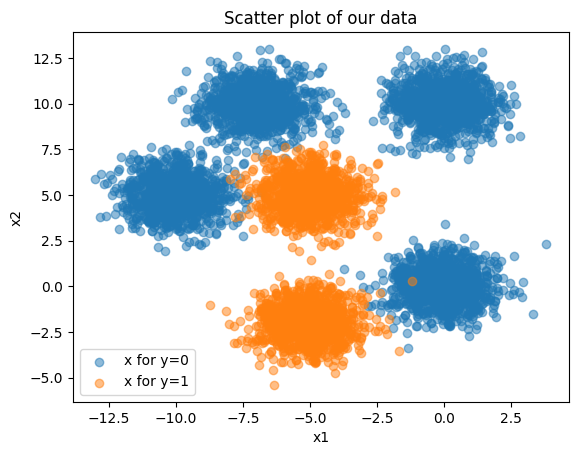

In [24]:
plt.figure()
plt.title("Scatter plot of our data")
plt.scatter(X_y_0[:, 0], X_y_0[:, 1], alpha=0.5, label="x for y=0")
plt.scatter(X_y_1[:, 0], X_y_1[:, 1], alpha=0.5, label="x for y=1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()